# 2. Analysis

## Setup

Run the data_cleaning notebook tho have access to all its contents in this shell

In [23]:
# We need to run the data_cleaning notebook this way to have 
# access to the tokenize_review function for the logistic regression

%run 1_data_cleaning.ipynb

Requirement already up-to-date: scikit-learn in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (0.22)
Requirement already up-to-date: spacy in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (2.2.3)
Requirement already up-to-date: pandas in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (0.25.3)
Requirement already up-to-date: seaborn in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (0.9.0)
Requirement already up-to-date: sklearn in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (0.0)
Requirement already up-to-date: nltk in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (3.4.5)
Requirement already up-to-date: jupyter in /Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages (1.0.0)


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package words to /Users/sylvain/nltk_data...
[nltk_data]   Package words is already up-to-date!
/Users/sylvain/anaconda3/envs/optimize/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 10/10 [00:00<00:00, 15.37it/s]


In [24]:
plt.rcParams['figure.figsize'] = [10, 7]

## 2.1 EDA

### Import dataset

In [25]:
data = pd.read_csv("../data/super_clean_dataset.csv") 

# Keep the first 100 elements to reduce the load on cpu

data.head()

,review,sentiment
0,reviewer mention watch oz episode hook right e...,positive
1,wonderful little production filming technique ...,positive
2,think wonderful way spend time hot sit air con...,positive
3,basically family little boy jake think zombie ...,negative
4,petter love time money visually stunning film ...,positive


In [26]:
# Base rate, delete later
a=data[data["sentiment"]=="positive"].shape
b=data[data["sentiment"]=="negative"].shape
base_rate=max(a[0], b[0])/data.shape[0]
print("The base rate is "+ str(base_rate))

The base rate is 0.5


## 2.2 Models

#### Splitting the dataset into training and test sets

In [27]:
X = data['review'] # the features we want to analyze, we can play with others too
y = data['sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

### 2.2.1 Logistic Model

In [28]:
# Notes: - saga is better than lbfgs for large datasets
#        - at default max_iter (1000) the model doesn't converge, 2000 doesn't either, 3000 works
classifier = LogisticRegression(solver="saga", max_iter=3000)

count_vector = CountVectorizer(tokenizer = tokenize_review, ngram_range = (1,2))

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', count_vector), ('classifier', classifier)])

# Fit Model
pipe.fit(X_train,y_train)

pipe.score(X_test, y_test)

0.8992

### Strongest Coefficients

In [29]:
def get_interesting_features(features):
    interesting_coefs = []
    for best_positive in sorted(features.items(), key=lambda x: x[1], reverse=True)[:5]:
        interesting_coefs.append(best_positive)

    for best_negative in sorted(features.items(), key=lambda x: x[1])[:5]:
        interesting_coefs.append(best_negative)
    return interesting_coefs

In [30]:
def graph_interesting_features(interesting_features):
    sorted_by_coef = sorted(interesting_features, key=lambda tup: tup[1], reverse=True)

    feature = [elem[0] for elem in sorted_by_coef]
    coef = [elem[1] for elem in sorted_by_coef]

    plt.bar(feature, coef)
    plt.xticks(feature, fontsize=12)
    plt.xticks(rotation=30)
    plt.show()

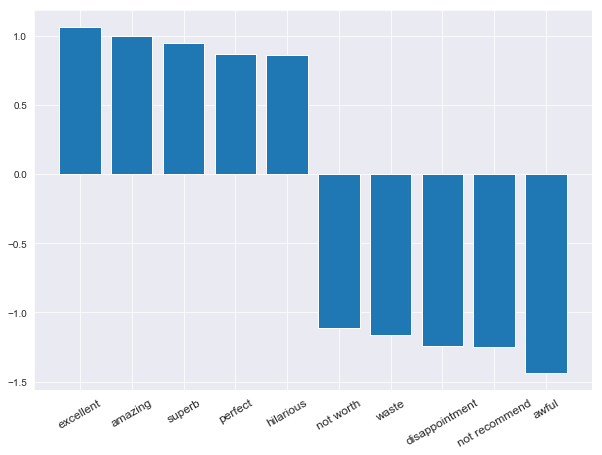

In [31]:
model_features = {
    word: coef for word, coef in zip(
        count_vector.get_feature_names(), classifier.coef_[0]
    )
}

interesting_features = get_interesting_features(model_features)
graph_interesting_features(interesting_features)

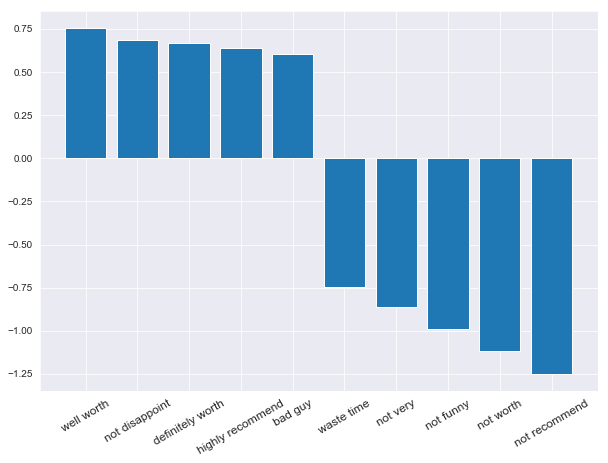

In [32]:
two_gram_features = {key: model_features[key] for key in model_features.keys() if len(key.split(' ')) == 2}
intersting_features = get_interesting_features(two_gram_features)
graph_interesting_features(intersting_features)

#### Results

In [33]:
#train set metrics
from sklearn.metrics import classification_report
target_pred = pipe.predict(X_train)
print(classification_report(y_train, target_pred))

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99     20004
    positive       0.99      0.99      0.99     19996

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



In [34]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = pipe.predict(X_test)
print(classification_report(y_test, target_pred))

              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      4996
    positive       0.89      0.91      0.90      5004

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



#### Confusion matrix

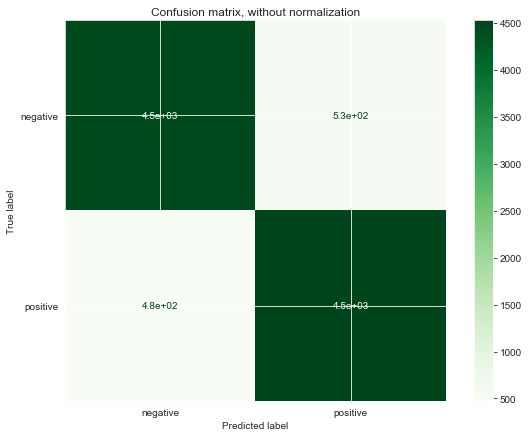

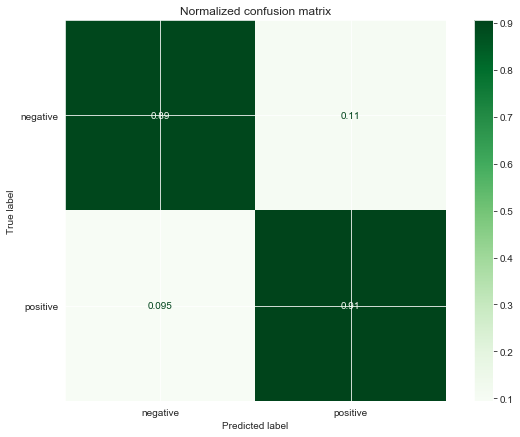

In [35]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

#### Precision Recall Curve


Average precision-recall score: 0.96


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.96')

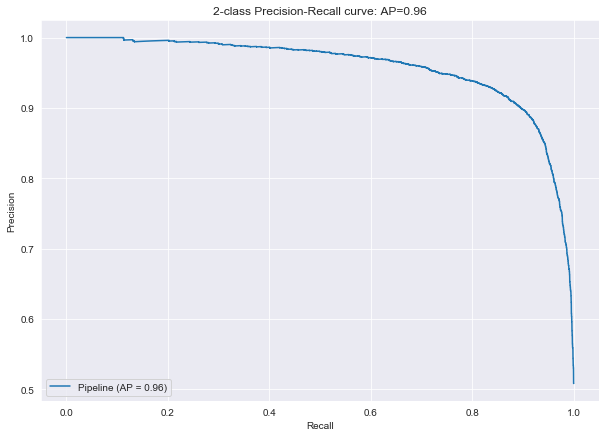

In [36]:
y_score = pipe.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score, pos_label="positive")

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(pipe, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

### 2.2.2 Decision Trees

In [37]:
X = count_vector.fit_transform(data['review'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [38]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [39]:
tree.score(X_test,y_test)

0.7389

In [40]:
tree.get_depth()

10

#### Tuning the depth of the tree

In [41]:
#scores = []
#for d in range(1, 21):
#    test_tree = DecisionTreeClassifier(criterion='entropy', max_depth=d)
#    test_tree.fit(X_train, y_train)
#    scores.append(test_tree.score(X_test, y_test))

In [42]:
#plt.plot(scores)
#plt.ylabel('accuracy', fontsize=15)
#plt.xlabel('depth', fontsize=15)

[Text(336.63191713483144, 363.22363636363633, 'X[157408] <= 0.5\nentropy = 1.0\nsamples = 40000\nvalue = [20004, 19996]'),
 Text(213.99143258426966, 328.6309090909091, 'X[2227844] <= 0.5\nentropy = 0.96\nsamples = 27873\nvalue = [10659, 17214]'),
 Text(149.02205056179776, 294.0381818181818, 'X[888523] <= 0.5\nentropy = 0.939\nsamples = 26363\nvalue = [9363, 17000]'),
 Text(88.24550561797753, 259.44545454545454, 'X[150918] <= 0.5\nentropy = 0.978\nsamples = 18782\nvalue = [7770, 11012]'),
 Text(55.40814606741573, 224.85272727272724, 'X[687152] <= 0.5\nentropy = 0.97\nsamples = 18131\nvalue = [7212, 10919]'),
 Text(36.52078651685393, 190.26, 'X[233374] <= 0.5\nentropy = 0.981\nsamples = 16760\nvalue = [7024, 9736]'),
 Text(20.062921348314607, 155.6672727272727, 'X[1207416] <= 0.5\nentropy = 0.973\nsamples = 16040\nvalue = [6468, 9572]'),
 Text(10.031460674157303, 121.07454545454544, 'X[1398536] <= 0.5\nentropy = 0.99\nsamples = 12473\nvalue = [5504, 6969]'),
 Text(5.015730337078652, 86.4

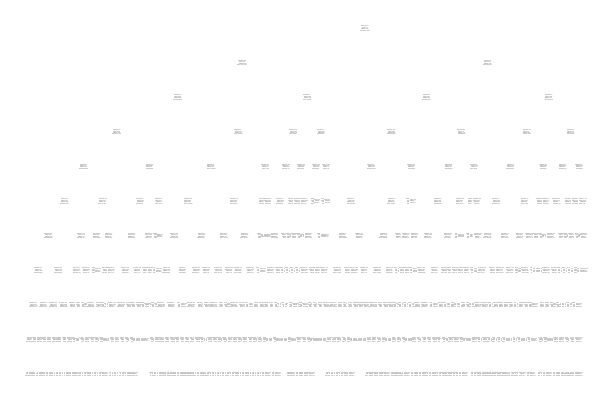

In [43]:
from sklearn.tree import plot_tree

plot_tree(tree)

In [44]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = tree.predict(X_test)
print(classification_report(y_test, target_pred))

              precision    recall  f1-score   support

    negative       0.79      0.65      0.71      4996
    positive       0.70      0.82      0.76      5004

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



#### Confusion matrix

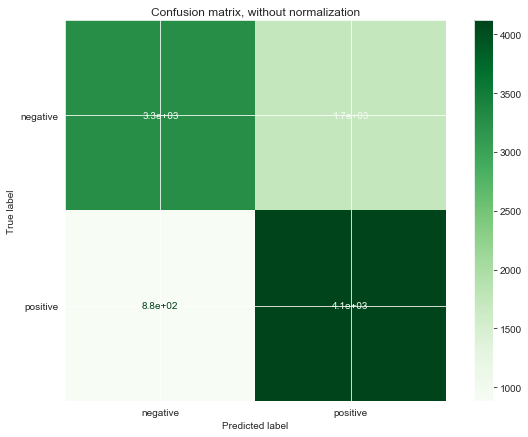

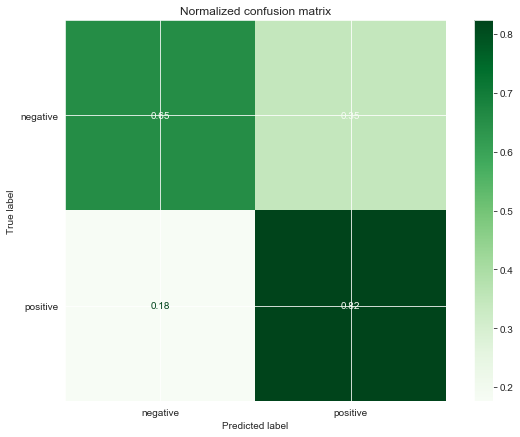

In [45]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

 We need to have: 
* Precision & Recall for all methods 
* Precision-Recall curve 
* Cross-validation for all methods 


###  2.2.3 KNN Classification

In [46]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [47]:
X = count_vector.fit_transform(data['review'])
y = data['sentiment']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [49]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [50]:
knn.score(X_test, y_test)

0.6168

In [51]:
#test set metrics
from sklearn.metrics import classification_report
target_pred = knn.predict(X_test)
print(classification_report(y_test, target_pred))

              precision    recall  f1-score   support

    negative       0.63      0.57      0.60      4996
    positive       0.61      0.67      0.64      5004

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



#### Tuning the value of n

In [52]:
#scores = []
#for n in range(1, 21):
#    knn = KNeighborsClassifier(n_neighbors=n, weights='uniform')
#    knn.fit(X_train, y_train)
#    scores.append(knn.score(X_test, y_test))

In [53]:
#plt.plot(scores)
#plt.ylabel('accuracy', fontsize=15)
#plt.xlabel('N', fontsize=15)

#### Confusion matrix

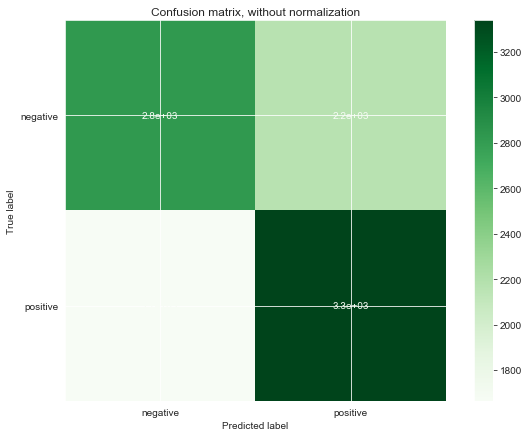

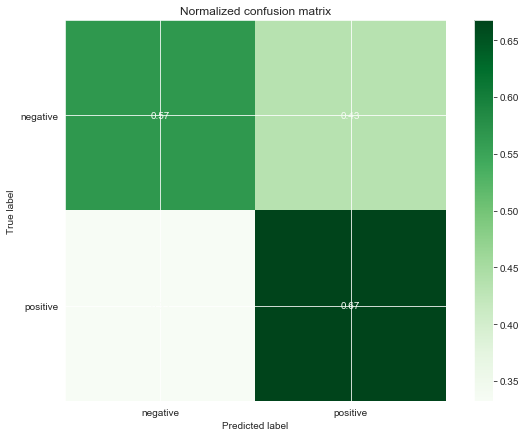

In [54]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Greens, normalize=normalize)
    disp.ax_.set_title(title)

### 2.2.4 Text similarity

In [55]:
stopwords = spacy_stopwords

# using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words = None)
bow = count.fit_transform(data)

# 2.3. Conclusion and Recommendation

From the analysis shown above we can see that the best performing method of classification of the reviews into binary class positive/negative is Logistic Regression method......